### Overview of the clinical problem

Degenerative spine conditions adversely affect people’s quality of life. Detecting these conditions is crucial for determining therapeutic plans for patients. Therefore, it is essential to develop methods for detecting and assessing the severity of degenerative spine conditions on imaging.

This challenge primarily focuses on identifying three types of conditions in the lumbar region of the spine (refer below for the anatomical overview). The three conditions we aim to assess are:

1. Foraminal narrowing (on either the left or right foramen at a specified level).
2. Subarticular stenosis (on either the left or right side at a specified level).
3. Canal stenosis (only at a specified level).

Each of these conditions can manifest at various levels within the spine itself, specifically at each vertebral disc (e.g., L4/5 corresponds to the vertebral disc between the L4 and L5 vertebral bodies).


For each of the conditions, you'll need to predict whether the degree of compression is normal/mild, moderate, or severe. You can refer to the example test submission `sample_submission.csv` to get a better idea for what we're looking for in terms of output. For each case, you'll have to output a score from 0 to 1 representing the probability of the patient having a specific grade (`normal_mild`, `moderate`, `severe`), at the spinal level (`l1_l2`, `l2_l3`, `l3_l4`, `l4_l5`, `l5_s1`), for that condition (`spinal_canal_stenosis`, `left_neural_foraminal_narrowing`, `right_neural_foraminal_narrowing`, `left_subarticular_stenosis`, `right_subarticular_stenosis`):


## Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
!pip install pydicom
import pydicom
import numpy as np
import os
import re
import glob
from tqdm import tqdm
import warnings
import pandas as pd
from collections import defaultdict
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import torchvision.models as models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Train/Test Split with Stratification


## Creating series_id_to_info
`series_id_to_info` has a structure like:
```
{series_id : {study_id, (dicom_paths: path1, path 2)}
```

**Purpose**: use to for splitting source training data into training and test splits


In [ ]:
import os
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ✅ Paths
DICOM_ROOT_DIR = "/content/drive/MyDrive/Final Project/data/train_images"
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# ✅ Step 1: Build series_id → {study_id, dicom_paths}
series_id_to_info = {}

print("🔍 Scanning folder structure to build series_id_to_info...")
for study_folder in tqdm(os.listdir(DICOM_ROOT_DIR), desc="Scanning studies"):
  #creating study_path
    study_path = os.path.join(DICOM_ROOT_DIR, study_folder)
    if not os.path.isdir(study_path):
        continue
  #creating series_path
    for series_folder in os.listdir(study_path):
        series_path = os.path.join(study_path, series_folder)
        if not os.path.isdir(series_path):
            continue
        #creating series_folder
        series_id = str(series_folder)
        #creating study_folder
        study_id = str(study_folder)
        #creating dicom_file_paths
        dicom_files = [
            os.path.join(series_path, f)
            for f in os.listdir(series_path)
            if f.lower().endswith(".dcm")
        ]
        #creating dict with structure series_id: (study_id, (dicom_path1, dicom_path2, ....))
        if dicom_files:
            series_id_to_info[series_id] = {
                "study_id": study_id,
                "dicom_paths": dicom_files
            }

print(f"✅ Found {len(series_id_to_info)} total series.")



🔍 Scanning folder structure to build series_id_to_info...


Scanning studies: 100%|██████████| 1976/1976 [00:06<00:00, 322.63it/s]

✅ Found 6294 total series.


## Split Source Training Data into training and test splits


1. used split series_ids into train_series_ids, and test_series_ids
2. then organized two meta data tables
* flat slice-level meta dataset (put aside for final training dataset assembly)
* **Output**:
  * train_dataset
  * test_dataset
* nested series_level meta dictionary for preprocessing like stacking volumes
* **Output**
  * train_series
  *test_series

In [ ]:
# ✅ Step 1: Set up Cache directory
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"

# ✅ Step 2: Split into train and test series
series_ids = list(series_id_to_info.keys())

train_series_ids, test_series_ids = train_test_split(
    series_ids,
    test_size=0.2,  # 20% test
    random_state=42,
    shuffle=True
)

print(f"✅ Train series: {len(train_series_ids)}")
print(f"✅ Test series: {len(test_series_ids)}")

# Creating two different meta data tables/dictionaries, a nested one and a flat one

# ✅ Step 3a: Build nested dicts
train_series = {}
test_series = {}

for sid in train_series_ids:
    train_series[sid] = series_id_to_info[sid]

for sid in test_series_ids:
    test_series[sid] = series_id_to_info[sid]

# ✅ Step 3b: Build flat datasets
train_dataset = []
test_dataset = []

#slice_level dictionary
for sid, info in train_series.items():
    for path in info['dicom_paths']:
        train_dataset.append({
            "study_id": info['study_id'],
            "series_id": sid,
            "dicom_path": path
        })

for sid, info in test_series.items():
    for path in info['dicom_paths']:
        test_dataset.append({
            "study_id": info['study_id'],
            "series_id": sid,
            "dicom_path": path
        })

print(f"✅ Train slices: {len(train_dataset)}")
print(f"✅ Test slices: {len(test_dataset)}")

# ✅ Step 5: Save everything
with open(os.path.join(CACHE_DIR, "train_series.pkl"), "wb") as f:
    pickle.dump(train_series, f)

with open(os.path.join(CACHE_DIR, "test_series.pkl"), "wb") as f:
    pickle.dump(test_series, f)

with open(os.path.join(CACHE_DIR, "train_dataset.pkl"), "wb") as f:
    pickle.dump(train_dataset, f)

with open(os.path.join(CACHE_DIR, "test_dataset.pkl"), "wb") as f:
    pickle.dump(test_dataset, f)

print("\n✅ All splits saved!")


✅ Train series: 5035
✅ Test series: 1259
✅ Train slices: 117704
✅ Test slices: 29514

✅ All splits saved!


# 2. Training Data Preprocessing Pipeline

## 2.1 Converting DICOMs to .npy's

1. creating a helper function `process_and_cache_slice` to take dicom path convert it into a .npy path and save the pixel array inside of it
2. using that function to perform those tasks on the `train_series` dicom_paths and saving the .npy paths and pixel arrays to 'npy_slices_train`

In [ ]:
# ✅ Load train split
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
with open(os.path.join(CACHE_DIR, "train_series.pkl"), "rb") as f:
    train_series = pickle.load(f)

# ✅ Directory to save .npy slices
SLICE_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/npy_slices_train"
os.makedirs(SLICE_SAVE_DIR, exist_ok=True)

# ✅ Helper function

def process_and_cache_slice(dicom_path, slice_save_root):
    try:
        dcm = pydicom.dcmread(dicom_path)
        pixel_array = dcm.pixel_array.astype(np.float32)

        # Extract study_id, series_id, and filename from the DICOM path
        parts = dicom_path.split(os.sep)
        study_id = parts[-3]    # assuming .../train_images/<study_id>/<series_id>/<filename>.dcm
        series_id = parts[-2]
        fname = os.path.basename(dicom_path).replace(".dcm", ".npy")

        # Create corresponding save path: /npy_slices_train/study_id/series_id/filename.npy
        save_dir = os.path.join(slice_save_root, study_id, series_id)
        os.makedirs(save_dir, exist_ok=True)

        npy_path = os.path.join(save_dir, fname)

        if not os.path.exists(npy_path):
            np.save(npy_path, pixel_array)

        return True
    except Exception as e:
        print(f"❌ Skipping {dicom_path}: {e}")
        return False


In [ ]:

# ✅ Collect all DICOM paths
all_train_dicom_paths = []
for series_id, info in train_series.items():
    all_train_dicom_paths.extend(info["dicom_paths"])

print(f"✅ Total slices to cache: {len(all_train_dicom_paths)}")

# ✅ Multithreaded saving
MAX_THREADS = 40  # adjust based on your CPU
print("🚀 Starting multithreaded DICOM → NPY conversion...")

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    list(tqdm(
        executor.map(process_and_cache_slice, all_train_dicom_paths, [SLICE_SAVE_DIR]*len(all_train_dicom_paths)),
        total=len(all_train_dicom_paths),
        desc="Saving dry-run slices"
    ))

print("\n✅ Finished caching all training slices!")


✅ Total slices to cache: 117704
🚀 Starting multithreaded DICOM → NPY conversion...


Saving dry-run slices: 100%|██████████| 117704/117704 [42:36<00:00, 46.04it/s]


✅ Finished caching all training slices!


In [ ]:
with open(os.path.join(CACHE_DIR, "all_train_dicom_paths.pkl"), "wb") as f:
    pickle.dump(all_train_dicom_paths, f)

## 2.2 Build slice-level metadata
1. load series descriptions into series_desc_map with dict structure {"series_id": "series_description"}

2. collect all of the .npy file paths into var `all_npy_paths`

3. create function called `extracts_metadata` that splits the .npy filepaths into component parts, and extracts the study_id, series_id, and instance number

4. call that function on `all_npy_paths` and store results in df called `df_slices`


In [ ]:
# ✅ Paths
SLICE_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/npy_slices_train"
series_desc_csv = "/content/drive/MyDrive/Final Project/data/train_series_descriptions.csv"

# ✅ Load series descriptions
df_desc = pd.read_csv(series_desc_csv, dtype=str)
series_desc_map = dict(zip(df_desc['series_id'], df_desc['series_description']))

# ✅ Collect ALL cached slices (full run)
all_npy_paths = glob.glob(os.path.join(SLICE_SAVE_DIR, "**", "**", "*.npy"), recursive=True)

print(f"✅ Found {len(all_npy_paths)} cached .npy slices for full run.")

# ✅ Helper function to extract metadata
def extract_metadata(npy_path):
    try:
        parts = npy_path.split(os.sep)
        study_id = parts[-3]
        series_id = parts[-2]
        fname = os.path.basename(npy_path)
        instance_number = int(os.path.splitext(fname)[0])  # "4.npy" → 4

        series_description = series_desc_map.get(series_id, "UNKNOWN")

        return {
            "slice_path": npy_path,
            "study_id": study_id,
            "series_id": series_id,
            "series_description": series_description,
            "instance_number": instance_number
        }
    except Exception as e:
        print(f"⚠️ Skipping {npy_path}: {e}")
        return None

# ✅ Multithreaded metadata extraction
MAX_THREADS = 40  # maximize now for speed!

print("🚀 Extracting slice metadata (full run) with multithreading...")

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    results = list(tqdm(executor.map(extract_metadata, all_npy_paths),
                        total=len(all_npy_paths),
                        desc="🔧 Building slice metadata"))

# ✅ Clean up
records = [r for r in results if r is not None]

# ✅ Build DataFrame
df_slices = pd.DataFrame(records)

print(f"\n✅ Built df_slices with {len(df_slices)} total slices.")
display(df_slices.head())


✅ Found 353112 cached .npy slices for full run.
🚀 Extracting slice metadata (full run) with multithreading...


🔧 Building slice metadata: 100%|██████████| 353112/353112 [00:00<00:00, 492279.10it/s]



✅ Built df_slices with 353112 total slices.


,slice_path,study_id,series_id,series_description,instance_number
0,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,3
1,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,21
2,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,18
3,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,9
4,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,13


In [ ]:
with open(os.path.join(CACHE_DIR, "all_npy_paths.pkl"), "wb") as f:
    pickle.dump(all_npy_paths, f)
with open(os.path.join(CACHE_DIR, "df_slices_train.pkl"), "wb") as f:
    pickle.dump(df_slices, f)

## 2.3 Create 3-slice mini-stacks

In [ ]:
df_slices_train.head()

,slice_path,study_id,series_id,series_description,instance_number
0,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,3
1,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,21
2,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,18
3,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,9
4,/content/drive/MyDrive/Final Project/data/npy_...,3753583176,3084368528,Sagittal T2/STIR,13


In [ ]:
# === Updated paths ===
train_labels_path = "/content/drive/MyDrive/Final Project/data/train.csv"
train_coords_path = "/content/drive/MyDrive/Final Project/data/train_label_coordinates.csv"
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
STACK_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/mini_stacks_train"
os.makedirs(STACK_SAVE_DIR, exist_ok=True)

# === Load label_df ===
label_df = pd.read_csv(train_coords_path, dtype=str)

# === Load severity labels ===
sev_labels = pd.read_csv(train_labels_path, dtype=str)
sev_labels.set_index('study_id', inplace=True)

# === Load cached slices ===
with open(os.path.join(CACHE_DIR, "df_slices_train.pkl"), "rb") as f:
    df_slices_train = pickle.load(f)

# === Condition → column mapping ===
condition_map = {
    "left_neural_foraminal_narrowing": "left_neural_foraminal_narrowing_{}",
    "right_neural_foraminal_narrowing": "right_neural_foraminal_narrowing_{}",
    "spinal_canal_stenosis": "spinal_canal_stenosis_{}",
    "left_subarticular_stenosis": "left_subarticular_stenosis_{}",
    "right_subarticular_stenosis": "right_subarticular_stenosis_{}",
}

def normalize_level(lvl):
    return lvl.lower().replace('/', '_')

def normalize_condition(cond):
    return cond.strip().lower().replace(' ', '_')

def create_single_mini_stack(row, df_slices, save_dir):
    """Create one mini-stack centered at a labeled slice."""
    try:
        sid = str(row.series_id)
        inst = int(row.instance_number)
        study_id = str(row.study_id)
        level = normalize_level(row.level)
        condition = normalize_condition(row['condition'])

        col_template = condition_map.get(condition)
        if col_template is not None:
            col_name = col_template.format(level)
            if col_name in sev_labels.columns and study_id in sev_labels.index:
                severity = sev_labels.loc[study_id, col_name]
            else:
                severity = "unknown"
        else:
            severity = "unknown"

        grouped = df_slices.groupby("series_id")
        if sid not in grouped.groups:
            return None

        series_slices = df_slices[df_slices['series_id'] == sid].copy()
        series_slices.sort_values("instance_number", inplace=True)

        slice_index = series_slices.index[series_slices['instance_number'] == inst].tolist()
        if len(slice_index) == 0:
            return None
        slice_index = slice_index[0]

        # Padding for edge cases
        if slice_index == series_slices.index.min():
            neighbors = [slice_index, slice_index, slice_index + 1]
        elif slice_index == series_slices.index.max():
            neighbors = [slice_index - 1, slice_index, slice_index]
        else:
            neighbors = [slice_index - 1, slice_index, slice_index + 1]

        paths = [series_slices.loc[n, "slice_path"] for n in neighbors]
        imgs = [np.load(p) for p in paths]

        stack = np.stack(imgs, axis=0).astype(np.float32)

        for k in range(3):
            sl = stack[k]
            mean, std = sl.mean(), sl.std()
            std = max(std, 1e-6)
            stack[k] = (sl - mean) / std

        resized_stack = np.zeros((3, 128, 128), dtype=np.float32)
        for k in range(3):
            resized_stack[k] = cv2.resize(stack[k], (128, 128), interpolation=cv2.INTER_AREA)

        stack_fname = f"{sid}_{inst}.npy"
        stack_path = os.path.join(save_dir, stack_fname)
        np.save(stack_path, resized_stack)

        return {
            "stack_path": stack_path,
            "series_id": sid,
            "study_id": study_id,
            "instance_number": inst,
            "level": level,
            "condition": condition,
            "severity": severity
        }
    except Exception:
        return None

# === Full-run settings ===
MAX_THREADS = 40

# === Launch multithreaded mini-stack creation ===
print("🚀 Starting full mini-stack creation...")

stack_records = []

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = [executor.submit(create_single_mini_stack, row, df_slices_train, STACK_SAVE_DIR)
               for idx, row in label_df.iterrows()]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Full-run stacks"):
        result = future.result()
        if result is not None:
            stack_records.append(result)

df_stacks_train = pd.DataFrame(stack_records)

# ✅ Save full-run output
df_stacks_train.dropna(axis=0, inplace=True)
with open(os.path.join(CACHE_DIR, "df_stacks_train.pkl"), "wb") as f:
    pickle.dump(df_stacks_train, f)

print(f"✅ Full mini-stacks created: {len(df_stacks_train)}")
print(df_stacks_train.head())



🚀 Starting full mini-stack creation...


Full-run stacks: 100%|██████████| 48692/48692 [2:00:46<00:00,  6.72it/s]


✅ Full mini-stacks created: 36272
                                          stack_path   series_id  study_id  \
0  /content/drive/MyDrive/Final Project/data/mini...  3219733239   7143189   
1  /content/drive/MyDrive/Final Project/data/mini...  2231042680  11340341   
2  /content/drive/MyDrive/Final Project/data/mini...   481125819   8785691   
3  /content/drive/MyDrive/Final Project/data/mini...  1178941473  38281420   
4  /content/drive/MyDrive/Final Project/data/mini...  3486248476   4646740   

   instance_number  level                         condition     severity  
0                4  l5_s1  right_neural_foraminal_narrowing  Normal/Mild  
1                5  l4_l5  right_neural_foraminal_narrowing     Moderate  
2                8  l5_s1             spinal_canal_stenosis  Normal/Mild  
3                3  l1_l2        left_subarticular_stenosis  Normal/Mild  
4                6  l1_l2   left_neural_foraminal_narrowing  Normal/Mild  


#### 2.3b Mini-Stack Sanity Check

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle

# Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
STACK_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/mini_stacks_train"

# Load mini-stack dataframe
with open(os.path.join(CACHE_DIR, "df_stacks_train.pkl"), "rb") as f:
    df_stacks_train = pickle.load(f)

# Load original labels
train_coords_path = "/content/drive/MyDrive/Final Project/data/train_label_coordinates.csv"
label_df = pd.read_csv(train_coords_path, dtype=str)

print(f"🔎 Original labeled slices: {len(label_df)}")
print(f"🔎 Mini-stacks created: {len(df_stacks_train)}")


# 1. ✅ Check missing stacks
label_ids = set(label_df['series_id'].astype(str) + "_" + label_df['instance_number'].astype(str))
stack_ids = set(df_stacks_train['series_id'].astype(str) + "_" + df_stacks_train['instance_number'].astype(str))

missing_stacks = label_ids - stack_ids
print(f"❗ Missing stacks: {len(missing_stacks)}")


# 2. ✅ Check file existence
missing_files = []
for p in tqdm(df_stacks_train['stack_path'], desc="Checking file existence"):
    if not os.path.exists(p):
        missing_files.append(p)
print(f"❗ Missing stack files: {len(missing_files)}")

# Sample 500 random stack paths
sampled_paths = random.sample(list(df_stacks_train['stack_path']), k=500)

def check_shape(p):
    try:
        arr = np.load(p)
        return (p, arr.shape) if arr.shape != (3, 128, 128) else None
    except Exception as e:
        print(f"❌ Error loading {p}: {e}")
        return (p, "error")

# Use multithreading
MAX_THREADS = 16  # you can increase if your machine can handle more

bad_shapes = []

print("🚀 Checking sampled stack shapes (multithreaded)...")
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = [executor.submit(check_shape, p) for p in sampled_paths]
    for fut in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Checking shapes"):
        result = fut.result()
        if result is not None:
            bad_shapes.append(result)

print(f"❗ Sampled stacks with bad shape or error: {len(bad_shapes)} (out of {len(sampled_paths)} checked)")
if bad_shapes:
    for p, shape in bad_shapes[:5]:  # show first 5 errors
        print(f"  ➡️  {p}: {shape}")



# 4. ✅ Check unknown severity
unknown_severity = df_stacks_train[df_stacks_train['severity'] == 'unknown']
print(f"❗ Stacks with unknown severity: {len(unknown_severity)}")

# 5. ✅ Check missing conditions or levels
print("🧹 Unique Conditions:", df_stacks_train['condition'].unique())
print("🧹 Unique Levels:", df_stacks_train['level'].unique())

print("\n✅ Validation finished!")



🔎 Original labeled slices: 48692
🔎 Mini-stacks created: 36272
❗ Missing stacks: 6135


Checking file existence: 100%|██████████| 36272/36272 [00:04<00:00, 7338.27it/s]


❗ Missing stack files: 0
🚀 Checking sampled stack shapes (multithreaded)...


Checking shapes: 100%|██████████| 500/500 [00:03<00:00, 128.33it/s]

❗ Sampled stacks with bad shape or error: 0 (out of 500 checked)
❗ Stacks with unknown severity: 0
🧹 Unique Conditions: ['right_neural_foraminal_narrowing' 'spinal_canal_stenosis'
 'left_subarticular_stenosis' 'left_neural_foraminal_narrowing'
 'right_subarticular_stenosis']
🧹 Unique Levels: ['l5_s1' 'l4_l5' 'l1_l2' 'l3_l4' 'l2_l3']

✅ Validation finished!


## 2.4 Filtering Mini-Stacks By Series Description

example: "Sagittal T2/STIR"

In [ ]:
# === Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
STACK_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/mini_stacks_train"
SERIES_DESC_CSV = "/content/drive/MyDrive/Final Project/data/train_series_descriptions.csv"

# === Load mini-stack dataframe
with open(os.path.join(CACHE_DIR, "df_stacks_train.pkl"), "rb") as f:
    df_stacks_train = pickle.load(f)

# === Load series description CSV
df_series_desc = pd.read_csv(SERIES_DESC_CSV, dtype=str)
#creates dict with structure series_id : series_description
series_desc_map = dict(zip(df_series_desc['series_id'], df_series_desc['series_description']))

# === Define allowed modalities and planes
ALLOWED_MODALITY = "T2"
ALLOWED_PLANES = ["SAG", "AXIAL"]  # we allow both sagittal and axial T2 sequences

def filter_by_series_description(df_stacks, series_desc_map):
    # where to store filtered images
    mask = []
    for sid in df_stacks['series_id']:
        desc = series_desc_map.get(str(sid), "")  # get us the series_description from train_series_description
        desc_up = desc.upper()
        if (ALLOWED_MODALITY in desc_up) and any(plane in desc_up for plane in ALLOWED_PLANES):  #checking if T2 AND SAG or AXIAL in series description
            mask.append(True)
        else:
            mask.append(False)
    return df_stacks[mask].reset_index(drop=True)

# === Apply filtering
print(f"📋 Mini-stacks BEFORE filtering: {len(df_stacks_train)}")
df_stacks_train_filtered = filter_by_series_description(df_stacks_train, series_desc_map)
print(f"📋 Mini-stacks AFTER filtering: {len(df_stacks_train_filtered)}")

# === Save filtered df
with open(os.path.join(CACHE_DIR, "df_stacks_train_filtered.pkl"), "wb") as f:
    pickle.dump(df_stacks_train_filtered, f)

print("✅ Saved filtered mini-stack dataframe!")


📋 Mini-stacks BEFORE filtering: 36258
📋 Mini-stacks AFTER filtering: 21804
✅ Saved filtered mini-stack dataframe!


## 2.5 Final assembly of training sets

In [ ]:
# === Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"

# === Load filtered mini-stack dataframe
with open(os.path.join(CACHE_DIR, "df_stacks_train_filtered.pkl"), "rb") as f:
    df_stacks_train_filtered = pickle.load(f)

print(f"✅ Loaded filtered mini-stacks: {len(df_stacks_train_filtered)}")

# === (Optional) Quick check of final structure
print(df_stacks_train_filtered.head(3))

# === Keep only necessary columns for training
final_train_df = df_stacks_train_filtered[['stack_path', 'severity', 'series_id', 'study_id', 'instance_number', 'level', 'condition']].copy()

print("\n✅ Final training dataframe columns:")
print(final_train_df.columns.tolist())

# === Save Final Version
with open(os.path.join(CACHE_DIR, "final_df_stacks_train.pkl"), "wb") as f:
    pickle.dump(final_train_df, f)

print(f"\n✅ Final training dataframe saved! Rows: {len(final_train_df)}")


✅ Loaded filtered mini-stacks: 21804
                                          stack_path   series_id  study_id  \
0  /content/drive/MyDrive/Final Project/data/mini...   481125819   8785691   
1  /content/drive/MyDrive/Final Project/data/mini...  1178941473  38281420   
2  /content/drive/MyDrive/Final Project/data/mini...  3543553307  11340341   

   instance_number  level                   condition     severity  
0                8  l5_s1       spinal_canal_stenosis  Normal/Mild  
1                3  l1_l2  left_subarticular_stenosis  Normal/Mild  
2               10  l5_s1       spinal_canal_stenosis  Normal/Mild  

✅ Final training dataframe columns:
['stack_path', 'severity', 'series_id', 'study_id', 'instance_number', 'level', 'condition']

✅ Final training dataframe saved! Rows: 21804


# 3. Model Training on the Training Split

## 3.1: Preparing SpineDataset and DataLoaders

In [ ]:
# === Step 3.1: Prepare SpineDataset and DataLoaders ===

# === Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
STACK_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/mini_stacks_train"

# === Load filtered mini-stacks DataFrame
with open(os.path.join(CACHE_DIR, "df_stacks_train_filtered.pkl"), "rb") as f:
    df_stacks_train = pickle.load(f)

# === Map severity to integer labels
label_map = {
    "Normal/Mild": 0,
    "Moderate": 1,
    "Severe": 2
}
df_stacks_train['label_idx'] = df_stacks_train['severity'].map(label_map)

print("✅ Severity label mapping done!")
print(df_stacks_train[['severity', 'label_idx']].drop_duplicates())



✅ Severity label mapping done!
       severity  label_idx
0   Normal/Mild          0
3      Moderate          1
25       Severe          2


In [ ]:
# === 🔥 Create Train/Val Split
train_df, val_df = train_test_split(
    df_stacks_train,
    test_size=0.2,
    stratify=df_stacks_train['label_idx'],  # ensures class distribution is preserved
    random_state=42
)

print(f"✅ Train Set Size: {len(train_df)}")
print(f"✅ Validation Set Size: {len(val_df)}")

# === Define Dataset class
class SpineDataset(Dataset):
    def __init__(self, df):
        self.paths = df['stack_path'].values
        self.labels = df['label_idx'].values.astype(np.int64)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        stack = np.load(self.paths[idx])  # shape (3, 128, 128)
        X = torch.from_numpy(stack).float()  # convert to float32 Tensor
        y = torch.tensor(self.labels[idx]).long()  # class label
        return X, y

# === Create Datasets
train_dataset = SpineDataset(train_df)
val_dataset   = SpineDataset(val_df)

# === Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # no shuffling for validation
    num_workers=4,
    pin_memory=True
)

print(f"✅ Final Train Loader: {len(train_dataset)} samples")
print(f"✅ Final Val Loader: {len(val_dataset)} samples")


✅ Train Set Size: 17443
✅ Validation Set Size: 4361
✅ Final Train Loader: 17443 samples
✅ Final Val Loader: 4361 samples


## 3.2 Define the models' architecture

### Model 1: Simple CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 8x64x64

            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)   # 16x32x32
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*32*32, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


### Model 2: Custom CNN: SpineMRIClassifier

In [ ]:
# === Define CNN Model
class SpineMRIClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(SpineMRIClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (16, 64, 64)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)   # Output: (64, 16, 16)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten to 64*16*16
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate model
model = SpineMRIClassifier(num_classes=3)

print("✅ Model architecture ready!")


✅ Model architecture ready!


### Model 3: Res-Net 18

In [ ]:
def get_resnet18_model(num_classes=3, pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # modify first conv if needed
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # change output layer
    return model


## 3.3 Training Setup for the 3 Models

🖥 Device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-9-802ab7b35fe5>:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🚀 Starting training for: SIMPLECNN

🌟 Epoch 1/10


Training:   0%|          | 0/546 [00:00<?, ?it/s]<ipython-input-9-802ab7b35fe5>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔹 Train Loss: 0.6903
🔹 Val Loss: 0.5541 | Val Acc: 0.7861
✅ Saved new best model: /content/drive/MyDrive/Final Project/models/best_model_simplecnn.pth

🌟 Epoch 2/10


🔹 Train Loss: 0.5033
🔹 Val Loss: 0.5905 | Val Acc: 0.7707

🌟 Epoch 3/10


🔹 Train Loss: 0.4391
🔹 Val Loss: 0.6101 | Val Acc: 0.7679

🌟 Epoch 4/10


🔹 Train Loss: 0.3936
🔹 Val Loss: 0.6052 | Val Acc: 0.7847

🌟 Epoch 5/10


🔹 Train Loss: 0.3032
🔹 Val Loss: 0.6521 | Val Acc: 0.7773

🌟 Epoch 6/10


🔹 Train Loss: 0.2840
🔹 Val Loss: 0.6851 | Val Acc: 0.7751

🌟 Epoch 7/10


🔹 Train Loss: 0.2735
🔹 Val Loss: 0.6941 | Val Acc: 0.7634

🌟 Epoch 8/10


🔹 Train Loss: 0.2286
🔹 Val Loss: 0.7183 | Val Acc: 0.7567

🌟 Epoch 9/10


🔹 Train Loss: 0.2201
🔹 Val Loss: 0.7354 | Val Acc: 0.7730

🌟 Epoch 10/10


🔹 Train Loss: 0.2134
🔹 Val Loss: 0.7798 | Val Acc: 0.7434

✅ Finished training simplecnn!


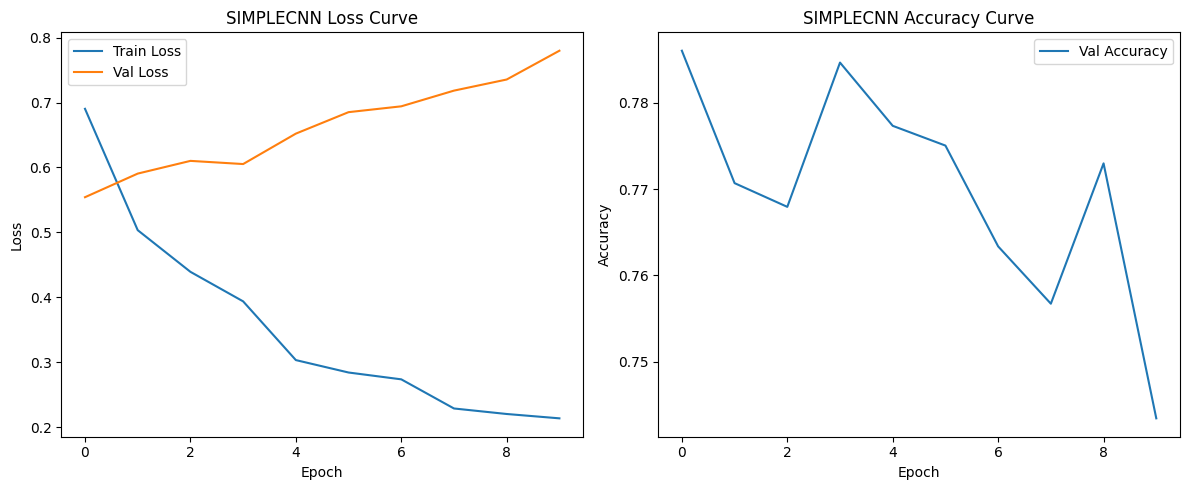


🚀 Starting training for: CUSTOMCNN

🌟 Epoch 1/10


🔹 Train Loss: 0.5709
🔹 Val Loss: 0.4999 | Val Acc: 0.7945
✅ Saved new best model: /content/drive/MyDrive/Final Project/models/best_model_customcnn.pth

🌟 Epoch 2/10


🔹 Train Loss: 0.4771
🔹 Val Loss: 0.4709 | Val Acc: 0.8014
✅ Saved new best model: /content/drive/MyDrive/Final Project/models/best_model_customcnn.pth

🌟 Epoch 3/10


🔹 Train Loss: 0.4378
🔹 Val Loss: 0.4609 | Val Acc: 0.8069
✅ Saved new best model: /content/drive/MyDrive/Final Project/models/best_model_customcnn.pth

🌟 Epoch 4/10


🔹 Train Loss: 0.4057
🔹 Val Loss: 0.4773 | Val Acc: 0.8088

🌟 Epoch 5/10


🔹 Train Loss: 0.3735
🔹 Val Loss: 0.4875 | Val Acc: 0.7929

🌟 Epoch 6/10


🔹 Train Loss: 0.3340
🔹 Val Loss: 0.5204 | Val Acc: 0.8033

🌟 Epoch 7/10


🔹 Train Loss: 0.2654
🔹 Val Loss: 0.5981 | Val Acc: 0.7968

🌟 Epoch 8/10


🔹 Train Loss: 0.2391
🔹 Val Loss: 0.6204 | Val Acc: 0.7989

🌟 Epoch 9/10


🔹 Train Loss: 0.2202
🔹 Val Loss: 0.6245 | Val Acc: 0.7888

🌟 Epoch 10/10


🔹 Train Loss: 0.1870
🔹 Val Loss: 0.7339 | Val Acc: 0.7927

✅ Finished training customcnn!


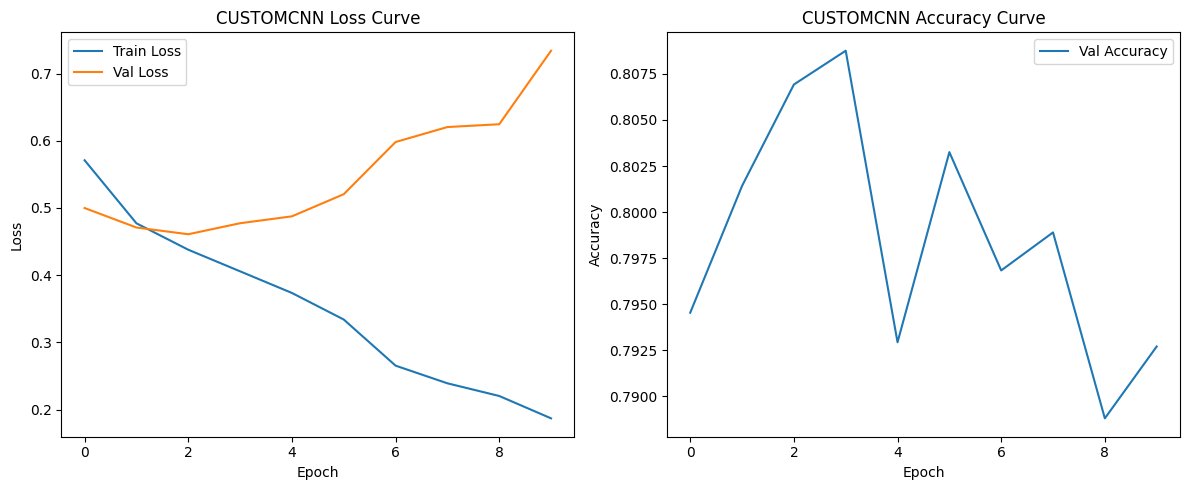


🚀 Starting training for: RESNET18

🌟 Epoch 1/10


🔹 Train Loss: 0.6002
🔹 Val Loss: 0.5302 | Val Acc: 0.7904
✅ Saved new best model: /content/drive/MyDrive/Final Project/models/best_model_resnet18.pth

🌟 Epoch 2/10


🔹 Train Loss: 0.4989
🔹 Val Loss: 0.4659 | Val Acc: 0.8090
✅ Saved new best model: /content/drive/MyDrive/Final Project/models/best_model_resnet18.pth

🌟 Epoch 3/10


🔹 Train Loss: 0.4641
🔹 Val Loss: 0.4522 | Val Acc: 0.8092
✅ Saved new best model: /content/drive/MyDrive/Final Project/models/best_model_resnet18.pth

🌟 Epoch 4/10


🔹 Train Loss: 0.4437
🔹 Val Loss: 0.5019 | Val Acc: 0.7890

🌟 Epoch 5/10


🔹 Train Loss: 0.4266
🔹 Val Loss: 0.4603 | Val Acc: 0.8108

🌟 Epoch 6/10


🔹 Train Loss: 0.4102
🔹 Val Loss: 0.4678 | Val Acc: 0.8000

🌟 Epoch 7/10


🔹 Train Loss: 0.3643
🔹 Val Loss: 0.4722 | Val Acc: 0.8037

🌟 Epoch 8/10


🔹 Train Loss: 0.3388
🔹 Val Loss: 0.5160 | Val Acc: 0.8069

🌟 Epoch 9/10


🔹 Train Loss: 0.3171
🔹 Val Loss: 0.5151 | Val Acc: 0.8062

🌟 Epoch 10/10


🔹 Train Loss: 0.2618
🔹 Val Loss: 0.6182 | Val Acc: 0.7991

✅ Finished training resnet18!


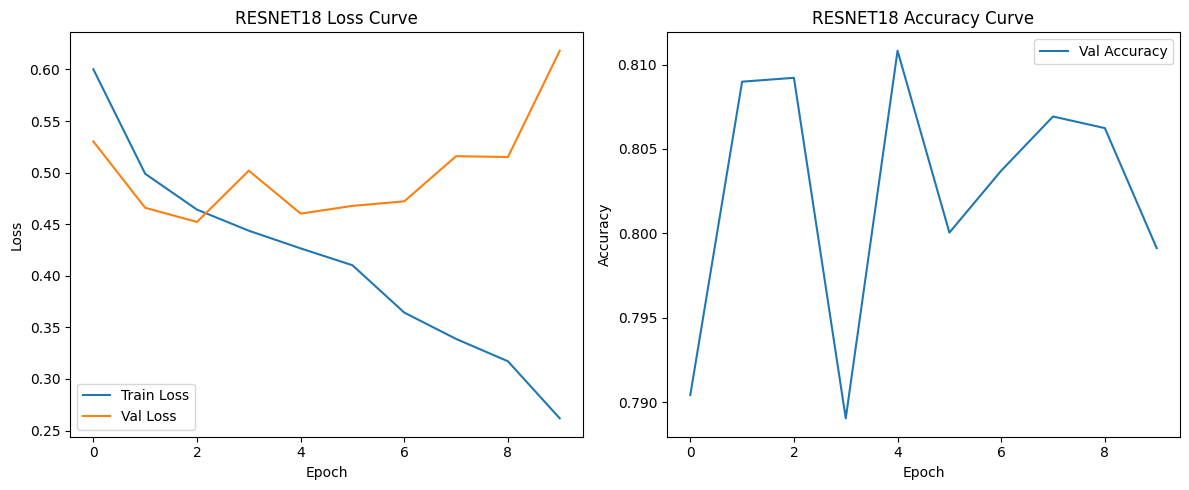

In [ ]:
# === Settings ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥 Device:", device)

# === Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
SAVE_DIR = "/content/drive/MyDrive/Final Project/models"
os.makedirs(SAVE_DIR, exist_ok=True)

# === Datasets and Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# === Model Architectures

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8 * 64 * 64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

def get_resnet18(num_classes=3):
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# === Training and Validation functions

def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0.0
    for X, y in tqdm(loader, desc="Training", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(X)
            loss = criterion(outputs, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * X.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Validating", leave=False):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            running_loss += loss.item() * X.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    val_loss = running_loss / len(loader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

def plot_training_curves(history, model_name):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"{model_name.upper()} Loss Curve")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title(f"{model_name.upper()} Accuracy Curve")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"{model_name}_training_curves.png"))
    plt.show()

def train_model(model, model_name):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    best_val_loss = float('inf')

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, NUM_EPOCHS+1):
        print(f"\n🌟 Epoch {epoch}/{NUM_EPOCHS}")

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion)

        print(f"🔹 Train Loss: {train_loss:.4f}")
        print(f"🔹 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(SAVE_DIR, f"best_model_{model_name}.pth")
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model: {save_path}")

    print(f"\n✅ Finished training {model_name}!")

    # Plot loss and accuracy curves
    plot_training_curves(history, model_name)

# === Models to Train
models_to_train = {
    "simplecnn": SimpleCNN(num_classes=3),
    "customcnn": CustomCNN(num_classes=3),
    "resnet18": get_resnet18(num_classes=3)
}

# === Train all models
for name, model in models_to_train.items():
    print(f"\n🚀 Starting training for: {name.upper()}")
    train_model(model, model_name=name)


# Break

# Testing Data Preprocessing Pipeline

### 2.1 Converting DICOMs to .npy's

1. creating a helper function `process_and_cache_slice` to take dicom path convert it into a .npy path and save the pixel array inside of it
2. using that function to perform those tasks on the `train_series` dicom_paths and saving the .npy paths and pixel arrays to 'npy_slices_train`

In [ ]:
# ✅ Load test split
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
with open(os.path.join(CACHE_DIR, "test_series.pkl"), "rb") as f:
    test_series = pickle.load(f)

# ✅ Directory to save .npy slices
SLICE_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/npy_slices_test"
os.makedirs(SLICE_SAVE_DIR, exist_ok=True)

# ✅ Helper function

def process_and_cache_slice(dicom_path, slice_save_root):
    try:
        dcm = pydicom.dcmread(dicom_path)
        pixel_array = dcm.pixel_array.astype(np.float32)

        # Extract study_id, series_id, and filename from the DICOM path
        parts = dicom_path.split(os.sep)
        study_id = parts[-3]    # assuming .../test_images/<study_id>/<series_id>/<filename>.dcm
        series_id = parts[-2]
        fname = os.path.basename(dicom_path).replace(".dcm", ".npy")

        # Create corresponding save path: /npy_slices_train/study_id/series_id/filename.npy
        save_dir = os.path.join(slice_save_root, study_id, series_id)
        os.makedirs(save_dir, exist_ok=True)

        npy_path = os.path.join(save_dir, fname)

        if not os.path.exists(npy_path):
            np.save(npy_path, pixel_array)

        return True
    except Exception as e:
        print(f"❌ Skipping {dicom_path}: {e}")
        return False


In [ ]:
# ✅ Collect all DICOM paths
all_test_dicom_paths = []
for series_id, info in test_series.items():
    all_test_dicom_paths.extend(info["dicom_paths"])

print(f"✅ Total slices to cache: {len(all_test_dicom_paths)}")

# ✅ Multithreaded saving
MAX_THREADS = 40  # adjust based on your CPU
print("🚀 Starting multithreaded DICOM → NPY conversion...")

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    list(tqdm(
        executor.map(process_and_cache_slice, all_test_dicom_paths, [SLICE_SAVE_DIR]*len(all_test_dicom_paths)),
        total=len(all_test_dicom_paths),
        desc="Saving dry-run slices"
    ))

print("\n✅ Finished caching all testing slices!")


✅ Total slices to cache: 29514
🚀 Starting multithreaded DICOM → NPY conversion...


Saving dry-run slices: 100%|██████████| 29514/29514 [10:21<00:00, 47.50it/s]


✅ Finished caching all testing slices!


In [ ]:
with open(os.path.join(CACHE_DIR, "all_test_dicom_paths.pkl"), "wb") as f:
    pickle.dump(all_test_dicom_paths, f)

### 2.2 Build slice-level metadata
1. load series descriptions into series_desc_map with dict structure {"series_id": "series_description"}

2. collect all of the .npy file paths into var `all_npy_paths`

3. create function called `extracts_metadata` that splits the .npy filepaths into component parts, and extracts the study_id, series_id, and instance number

4. call that function on `all_npy_paths` and store results in df called `df_slices`


In [ ]:
# ✅ Paths
SLICE_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/npy_slices_test"
series_desc_csv = "/content/drive/MyDrive/Final Project/data/train_series_descriptions.csv"

# ✅ Load series descriptions
df_desc = pd.read_csv(series_desc_csv, dtype=str)
series_desc_map = dict(zip(df_desc['series_id'], df_desc['series_description']))

# ✅ Collect ALL cached slices (full run)
all_npy_paths = glob.glob(os.path.join(SLICE_SAVE_DIR, "**", "**", "*.npy"), recursive=True)

print(f"✅ Found {len(all_npy_paths)} cached .npy slices for full run.")

# ✅ Helper function to extract metadata
def extract_metadata(npy_path):
    try:
        parts = npy_path.split(os.sep)
        study_id = parts[-3]
        series_id = parts[-2]
        fname = os.path.basename(npy_path)
        instance_number = int(os.path.splitext(fname)[0])  # "4.npy" → 4

        series_description = series_desc_map.get(series_id, "UNKNOWN")

        return {
            "slice_path": npy_path,
            "study_id": study_id,
            "series_id": series_id,
            "series_description": series_description,
            "instance_number": instance_number
        }
    except Exception as e:
        print(f"⚠️ Skipping {npy_path}: {e}")
        return None

# ✅ Multithreaded metadata extraction
MAX_THREADS = 40  # maximize now for speed!

print("🚀 Extracting slice metadata (full run) with multithreading...")

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    results = list(tqdm(executor.map(extract_metadata, all_npy_paths),
                        total=len(all_npy_paths),
                        desc="🔧 Building slice metadata"))

# ✅ Clean up
records = [r for r in results if r is not None]

# ✅ Build DataFrame
df_slices = pd.DataFrame(records)

print(f"\n✅ Built df_slices with {len(df_slices)} total slices.")
display(df_slices.head())


✅ Found 88542 cached .npy slices for full run.
🚀 Extracting slice metadata (full run) with multithreading...


🔧 Building slice metadata: 100%|██████████| 88542/88542 [00:00<00:00, 562395.23it/s]



✅ Built df_slices with 88542 total slices.


,slice_path,study_id,series_id,series_description,instance_number
0,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,11
1,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,29
2,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,20
3,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,12
4,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,22


In [ ]:
with open(os.path.join(CACHE_DIR, "all_npy_paths_test.pkl"), "wb") as f:
    pickle.dump(all_npy_paths, f)
with open(os.path.join(CACHE_DIR, "df_slices_test.pkl"), "wb") as f:
    pickle.dump(df_slices, f)

### 2.3 Create 3-slice mini-stacks

In [ ]:
with open(os.path.join(CACHE_DIR, "df_slices_test.pkl"), "rb") as f:
    df_slices_test = pickle.load(f)
df_slices_test.head()

,slice_path,study_id,series_id,series_description,instance_number
0,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,11
1,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,29
2,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,20
3,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,12
4,/content/drive/MyDrive/Final Project/data/npy_...,2880587926,1218035662,Axial T2,22


In [ ]:
# === Updated paths ===
test_labels_path = "/content/drive/MyDrive/Final Project/data/train.csv"
test_coords_path = "/content/drive/MyDrive/Final Project/data/train_label_coordinates.csv"
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
STACK_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/mini_stacks_test"
os.makedirs(STACK_SAVE_DIR, exist_ok=True)

# === Load label_df ===
label_df = pd.read_csv(test_coords_path, dtype=str)

# === Load severity labels ===
sev_labels = pd.read_csv(test_labels_path, dtype=str)
sev_labels.set_index('study_id', inplace=True)

# === Load cached slices ===
with open(os.path.join(CACHE_DIR, "df_slices_test.pkl"), "rb") as f:
    df_slices_test = pickle.load(f)

# === Condition → column mapping ===
condition_map = {
    "left_neural_foraminal_narrowing": "left_neural_foraminal_narrowing_{}",
    "right_neural_foraminal_narrowing": "right_neural_foraminal_narrowing_{}",
    "spinal_canal_stenosis": "spinal_canal_stenosis_{}",
    "left_subarticular_stenosis": "left_subarticular_stenosis_{}",
    "right_subarticular_stenosis": "right_subarticular_stenosis_{}",
}

def normalize_level(lvl):
    return lvl.lower().replace('/', '_')

def normalize_condition(cond):
    return cond.strip().lower().replace(' ', '_')

def create_single_mini_stack(row, df_slices, save_dir):
    """Create one mini-stack centered at a labeled slice."""
    try:
        sid = str(row.series_id)
        inst = int(row.instance_number)
        study_id = str(row.study_id)
        level = normalize_level(row.level)
        condition = normalize_condition(row['condition'])

        col_template = condition_map.get(condition)
        if col_template is not None:
            col_name = col_template.format(level)
            if col_name in sev_labels.columns and study_id in sev_labels.index:
                severity = sev_labels.loc[study_id, col_name]
            else:
                severity = "unknown"
        else:
            severity = "unknown"

        grouped = df_slices.groupby("series_id")
        if sid not in grouped.groups:
            return None

        series_slices = df_slices[df_slices['series_id'] == sid].copy()
        series_slices.sort_values("instance_number", inplace=True)

        slice_index = series_slices.index[series_slices['instance_number'] == inst].tolist()
        if len(slice_index) == 0:
            return None
        slice_index = slice_index[0]

        # Padding for edge cases
        if slice_index == series_slices.index.min():
            neighbors = [slice_index, slice_index, slice_index + 1]
        elif slice_index == series_slices.index.max():
            neighbors = [slice_index - 1, slice_index, slice_index]
        else:
            neighbors = [slice_index - 1, slice_index, slice_index + 1]

        paths = [series_slices.loc[n, "slice_path"] for n in neighbors]
        imgs = [np.load(p) for p in paths]

        stack = np.stack(imgs, axis=0).astype(np.float32)

        for k in range(3):
            sl = stack[k]
            mean, std = sl.mean(), sl.std()
            std = max(std, 1e-6)
            stack[k] = (sl - mean) / std

        resized_stack = np.zeros((3, 128, 128), dtype=np.float32)
        for k in range(3):
            resized_stack[k] = cv2.resize(stack[k], (128, 128), interpolation=cv2.INTER_AREA)

        stack_fname = f"{sid}_{inst}.npy"
        stack_path = os.path.join(save_dir, stack_fname)
        np.save(stack_path, resized_stack)

        return {
            "stack_path": stack_path,
            "series_id": sid,
            "study_id": study_id,
            "instance_number": inst,
            "level": level,
            "condition": condition,
            "severity": severity
        }
    except Exception:
        return None

# === Full-run settings ===
MAX_THREADS = 40

# === Launch multithreaded mini-stack creation ===
print("🚀 Starting full mini-stack creation...")

stack_records = []

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = [executor.submit(create_single_mini_stack, row, df_slices_test, STACK_SAVE_DIR)
               for idx, row in label_df.iterrows()]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Full-run stacks"):
        result = future.result()
        if result is not None:
            stack_records.append(result)

df_stacks_test = pd.DataFrame(stack_records)

# ✅ Save full-run output
df_stacks_test.dropna(axis=0, inplace=True)
with open(os.path.join(CACHE_DIR, "df_stacks_test.pkl"), "wb") as f:
    pickle.dump(df_stacks_test, f)

print(f"✅ Full mini-stacks created: {len(df_stacks_test)}")
print(df_stacks_test.head())



🚀 Starting full mini-stack creation...


Full-run stacks: 100%|██████████| 48692/48692 [15:58<00:00, 50.82it/s]


✅ Full mini-stacks created: 9274
                                          stack_path   series_id    study_id  \
0  /content/drive/MyDrive/Final Project/data/mini...   926922520  1119763924   
1  /content/drive/MyDrive/Final Project/data/mini...   926922520  1119763924   
2  /content/drive/MyDrive/Final Project/data/mini...   230391479  1560475098   
3  /content/drive/MyDrive/Final Project/data/mini...   926922520  1119763924   
4  /content/drive/MyDrive/Final Project/data/mini...  1860642079  1639920408   

   instance_number  level                         condition     severity  
0               23  l3_l4        left_subarticular_stenosis     Moderate  
1               14  l2_l3       right_subarticular_stenosis  Normal/Mild  
2               16  l4_l5   left_neural_foraminal_narrowing  Normal/Mild  
3               14  l2_l3        left_subarticular_stenosis  Normal/Mild  
4                8  l2_l3  right_neural_foraminal_narrowing     Moderate  


##### 2.3b Mini-Stack Sanity Check

In [ ]:
import random
# Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
STACK_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/mini_stacks_test"

# Load mini-stack dataframe
with open(os.path.join(CACHE_DIR, "df_stacks_test.pkl"), "rb") as f:
    df_stacks_test = pickle.load(f)

# Load original labels
test_coords_path = "/content/drive/MyDrive/Final Project/data/train_label_coordinates.csv"
label_df = pd.read_csv(test_coords_path, dtype=str)

print(f"🔎 Original labeled slices: {len(label_df)}")
print(f"🔎 Mini-stacks created: {len(df_stacks_test)}")


# 1. ✅ Check missing stacks
label_ids = set(label_df['series_id'].astype(str) + "_" + label_df['instance_number'].astype(str))
stack_ids = set(df_stacks_test['series_id'].astype(str) + "_" + df_stacks_test['instance_number'].astype(str))

missing_stacks = label_ids - stack_ids
print(f"❗ Missing stacks: {len(missing_stacks)}")


# 2. ✅ Check file existence
missing_files = []
for p in tqdm(df_stacks_test['stack_path'], desc="Checking file existence"):
    if not os.path.exists(p):
        missing_files.append(p)
print(f"❗ Missing stack files: {len(missing_files)}")

# Sample 500 random stack paths
sampled_paths = random.sample(list(df_stacks_test['stack_path']), k=500)

def check_shape(p):
    try:
        arr = np.load(p)
        return (p, arr.shape) if arr.shape != (3, 128, 128) else None
    except Exception as e:
        print(f"❌ Error loading {p}: {e}")
        return (p, "error")

# Use multithreading
MAX_THREADS = 16  # you can increase if your machine can handle more

bad_shapes = []

print("🚀 Checking sampled stack shapes (multithreaded)...")
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = [executor.submit(check_shape, p) for p in sampled_paths]
    for fut in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Checking shapes"):
        result = fut.result()
        if result is not None:
            bad_shapes.append(result)

print(f"❗ Sampled stacks with bad shape or error: {len(bad_shapes)} (out of {len(sampled_paths)} checked)")
if bad_shapes:
    for p, shape in bad_shapes[:5]:  # show first 5 errors
        print(f"  ➡️  {p}: {shape}")



# 4. ✅ Check unknown severity
unknown_severity = df_stacks_test[df_stacks_test['severity'] == 'unknown']
print(f"❗ Stacks with unknown severity: {len(unknown_severity)}")

# 5. ✅ Check missing conditions or levels
print("🧹 Unique Conditions:", df_stacks_test['condition'].unique())
print("🧹 Unique Levels:", df_stacks_test['level'].unique())

print("\n✅ Validation finished!")



🔎 Original labeled slices: 48692
🔎 Mini-stacks created: 9274
❗ Missing stacks: 19904


Checking file existence: 100%|██████████| 9274/9274 [00:01<00:00, 6780.79it/s]


❗ Missing stack files: 0
🚀 Checking sampled stack shapes (multithreaded)...


Checking shapes: 100%|██████████| 500/500 [00:01<00:00, 349.67it/s]

❗ Sampled stacks with bad shape or error: 0 (out of 500 checked)
❗ Stacks with unknown severity: 0
🧹 Unique Conditions: ['left_subarticular_stenosis' 'right_subarticular_stenosis'
 'left_neural_foraminal_narrowing' 'right_neural_foraminal_narrowing'
 'spinal_canal_stenosis']
🧹 Unique Levels: ['l3_l4' 'l2_l3' 'l4_l5' 'l1_l2' 'l5_s1']

✅ Validation finished!


### 2.4 Filtering Mini-Stacks By Series Description

example: "Sagittal T2/STIR"

In [ ]:
# === Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"
STACK_SAVE_DIR = "/content/drive/MyDrive/Final Project/data/mini_stacks_test"
SERIES_DESC_CSV = "/content/drive/MyDrive/Final Project/data/train_series_descriptions.csv"

# === Load mini-stack dataframe
with open(os.path.join(CACHE_DIR, "df_stacks_test.pkl"), "rb") as f:
    df_stacks_test = pickle.load(f)

# === Load series description CSV
df_series_desc = pd.read_csv(SERIES_DESC_CSV, dtype=str)
#creates dict with structure series_id : series_description
series_desc_map = dict(zip(df_series_desc['series_id'], df_series_desc['series_description']))

# === Define allowed modalities and planes
ALLOWED_MODALITY = "T2"
ALLOWED_PLANES = ["SAG", "AXIAL"]  # we allow both sagittal and axial T2 sequences

def filter_by_series_description(df_stacks, series_desc_map):
    # where to store filtered images
    mask = []
    for sid in df_stacks['series_id']:
        desc = series_desc_map.get(str(sid), "")  # get us the series_description from train_series_description
        desc_up = desc.upper()
        if (ALLOWED_MODALITY in desc_up) and any(plane in desc_up for plane in ALLOWED_PLANES):  #checking if T2 AND SAG or AXIAL in series description
            mask.append(True)
        else:
            mask.append(False)
    return df_stacks[mask].reset_index(drop=True)

# === Apply filtering
print(f"📋 Mini-stacks BEFORE filtering: {len(df_stacks_test)}")
df_stacks_test_filtered = filter_by_series_description(df_stacks_test, series_desc_map)
print(f"📋 Mini-stacks AFTER filtering: {len(df_stacks_test_filtered)}")

# === Save filtered df
with open(os.path.join(CACHE_DIR, "df_stacks_test_filtered.pkl"), "wb") as f:
    pickle.dump(df_stacks_test_filtered, f)

print("✅ Saved filtered mini-stack dataframe!")


📋 Mini-stacks BEFORE filtering: 9274
📋 Mini-stacks AFTER filtering: 5402
✅ Saved filtered mini-stack dataframe!


### 2.5 Final assembly of training sets

In [ ]:
# === Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"

# === Load filtered mini-stack dataframe
with open(os.path.join(CACHE_DIR, "df_stacks_test_filtered.pkl"), "rb") as f:
    df_stacks_test_filtered = pickle.load(f)

print(f"✅ Loaded filtered mini-stacks: {len(df_stacks_test_filtered)}")

# === (Optional) Quick check of final structure
print(df_stacks_test_filtered.head(3))

# === Keep only necessary columns for testing
final_test_df = df_stacks_test_filtered[['stack_path', 'severity', 'series_id', 'study_id', 'instance_number', 'level', 'condition']].copy()

print("\n✅ Final testing dataframe columns:")
print(final_test_df.columns.tolist())

# === Save Final Version
with open(os.path.join(CACHE_DIR, "final_df_stacks_test.pkl"), "wb") as f:
    pickle.dump(final_test_df, f)

print(f"\n✅ Final testing dataframe saved! Rows: {len(final_test_df)}")


✅ Loaded filtered mini-stacks: 5402
                                          stack_path  series_id    study_id  \
0  /content/drive/MyDrive/Final Project/data/mini...  926922520  1119763924   
1  /content/drive/MyDrive/Final Project/data/mini...  926922520  1119763924   
2  /content/drive/MyDrive/Final Project/data/mini...  926922520  1119763924   

   instance_number  level                    condition     severity  
0               23  l3_l4   left_subarticular_stenosis     Moderate  
1               14  l2_l3  right_subarticular_stenosis  Normal/Mild  
2               14  l2_l3   left_subarticular_stenosis  Normal/Mild  

✅ Final testing dataframe columns:
['stack_path', 'severity', 'series_id', 'study_id', 'instance_number', 'level', 'condition']

✅ Final testing dataframe saved! Rows: 5402


Rember for model training
to differentiate model savepoint names
f"best_model_{model_name}.pth")
to like
f"best_test_model_{model_name}.pth") or something

Or maybe you don't need to do that?

# 4. Evaluation on the Held-out Test Set

## Step 4.1 Test Loader Prep

In [ ]:
# === 4.0 Prepare Final Test Set ===

# Paths
CACHE_DIR = "/content/drive/MyDrive/Final Project/data/cache"

# Load final test dataframe
with open(os.path.join(CACHE_DIR, "final_df_stacks_test.pkl"), "rb") as f:
    final_test_df = pickle.load(f)

print(f"✅ Loaded final test set: {len(final_test_df)} samples")

# Label mapping
label_map = {
    "Normal/Mild": 0,
    "Moderate": 1,
    "Severe": 2
}

# Map severity column to integer labels
final_test_df['label_idx'] = final_test_df['severity'].map(label_map)

# Define SpineDataset (same as before)
class SpineDataset(Dataset):
    def __init__(self, df):
        self.paths = df['stack_path'].values
        self.labels = df['label_idx'].values.astype(np.int64)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        stack = np.load(self.paths[idx])  # shape (3, 128, 128)
        X = torch.from_numpy(stack).float()
        y = torch.tensor(self.labels[idx]).long()
        return X, y

# Create Test Dataset and Loader
test_dataset = SpineDataset(final_test_df)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,       # match train/val
    shuffle=False,       # important! no shuffle for test
    num_workers=4,
    pin_memory=True
)

print(f"✅ Test Dataset Size: {len(test_dataset)} samples")


✅ Loaded final test set: 5402 samples
✅ Test Dataset Size: 5402 samples


## 4.2 Redefine Model Architecture

### Model 1: Simple CNN

In [ ]:
# === SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8 * 64 * 64, num_classes)
        )
    def forward(self, x):
        return self.net(x)



print("✅ Model architecture ready!")

✅ Model architecture ready!


### Model 2: Custom CNN: SpineMRIClassifier

In [ ]:
# === CustomCNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


print("✅ Model architecture ready!")


✅ Model architecture ready!


### Model 3: Res-Net 18

In [ ]:
# === ResNet18
def get_resnet18(num_classes=3):
    model = models.resnet18(weights=None)  # no pretraining
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

print("✅ Model architecture ready!")


✅ Model architecture ready!


## Step 4.2: Inference on Test Data for All Models


🚀 Running inference for: SIMPLECNN


Inferencing:   0%|          | 0/169 [00:00<?, ?it/s]<ipython-input-26-fb03b40c552c>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



🔍 Per-class metrics:
Class            Precision     Recall   F1-Score    Support
Normal/Mild           0.79       0.98       0.88       4128
Moderate              0.41       0.09       0.14        847
Severe                0.51       0.11       0.18        427


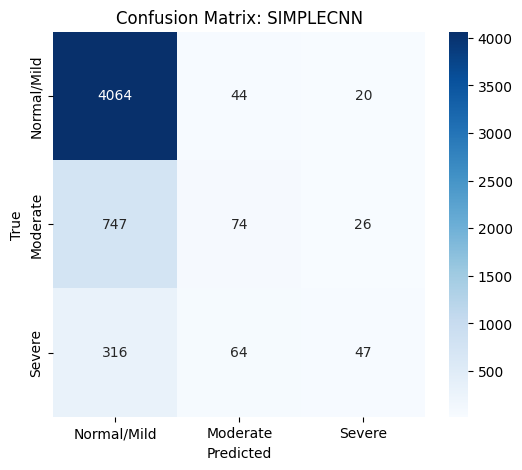

✅ Saved confusion matrix to /content/drive/MyDrive/Final Project/figures/confusion_matrix_simplecnn.png

🚀 Running inference for: CUSTOMCNN


Inferencing:   0%|          | 0/169 [00:00<?, ?it/s]<ipython-input-26-fb03b40c552c>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



🔍 Per-class metrics:
Class            Precision     Recall   F1-Score    Support
Normal/Mild           0.88       0.93       0.90       4128
Moderate              0.47       0.35       0.40        847
Severe                0.53       0.50       0.52        427


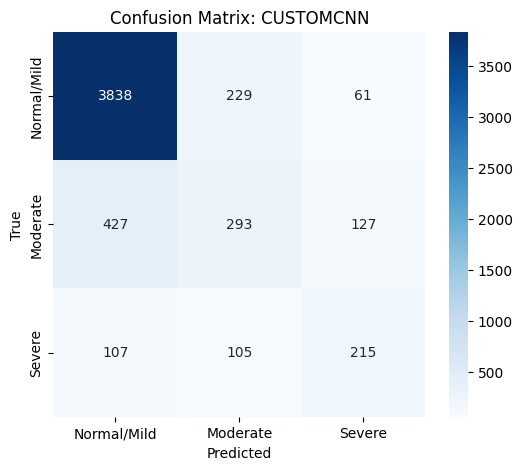

✅ Saved confusion matrix to /content/drive/MyDrive/Final Project/figures/confusion_matrix_customcnn.png

🚀 Running inference for: RESNET18


Inferencing:   0%|          | 0/169 [00:00<?, ?it/s]<ipython-input-26-fb03b40c552c>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



🔍 Per-class metrics:
Class            Precision     Recall   F1-Score    Support
Normal/Mild           0.86       0.96       0.91       4128
Moderate              0.50       0.25       0.34        847
Severe                0.61       0.49       0.54        427


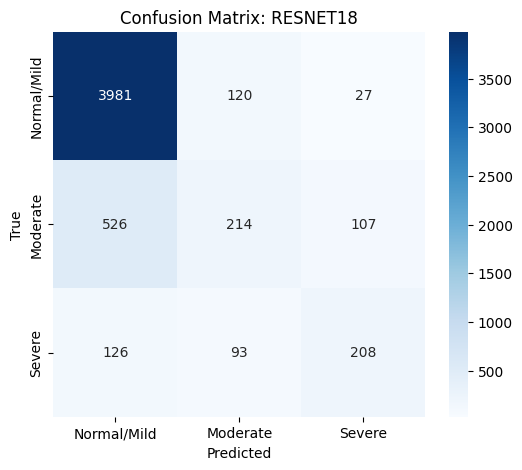

✅ Saved confusion matrix to /content/drive/MyDrive/Final Project/figures/confusion_matrix_resnet18.png

✅ Final Test Set Metrics:
           Accuracy  Precision    Recall  F1 Score  Support (Test Samples)
simplecnn  0.774713   0.568212  0.393978  0.400942                  5402.0
customcnn  0.804517   0.626221  0.593063  0.606230                  5402.0
resnet18   0.815068   0.656210  0.568055  0.595237                  5402.0

✅ Results table saved to /content/drive/MyDrive/Final Project/figures/final_test_results.csv


In [ ]:
# === Paths ===
SAVE_DIR = "/content/drive/MyDrive/Final Project/models"
FIGURE_DIR = "/content/drive/MyDrive/Final Project/figures"
os.makedirs(FIGURE_DIR, exist_ok=True)

# === Inference Function ===
def inference_on_test(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Inferencing", leave=False):
            X, y = X.to(device), y.to(device)
            with autocast():
                logits = model(X)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    return y_true, y_pred

# === Label Names ===
label_names = ["Normal/Mild", "Moderate", "Severe"]

# === Evaluation Loop for All Models ===
results = {}

for model_name in ["simplecnn", "customcnn", "resnet18"]:
    print(f"\n🚀 Running inference for: {model_name.upper()}")

    # Load corresponding model architecture
    if model_name == "simplecnn":
        model = SimpleCNN(num_classes=3)
    elif model_name == "customcnn":
        model = CustomCNN(num_classes=3)
    elif model_name == "resnet18":
        model = get_resnet18(num_classes=3)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Load saved best weights
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, f"best_model_{model_name}.pth")))
    model.to(device)

    # Run inference
    y_true, y_pred = inference_on_test(model, test_loader, device)

    # === Metrics Computation ===
    report = classification_report(y_true, y_pred, output_dict=True, target_names=label_names)

    acc = accuracy_score(y_true, y_pred)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    support = sum(report[label]['support'] for label in label_names)

    results[model_name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Support (Test Samples)": support
    }

    # 🎯 Print nice per-class breakdown
    print("\n🔍 Per-class metrics:")
    print(f"{'Class':<15} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    for label in label_names:
        metrics = report[label]
        print(f"{label:<15} {metrics['precision']:>10.2f} {metrics['recall']:>10.2f} {metrics['f1-score']:>10.2f} {int(metrics['support']):>10}")

    # 🎯 Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Confusion Matrix: {model_name.upper()}")
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save Confusion Matrix Figure
    save_path = os.path.join(FIGURE_DIR, f"confusion_matrix_{model_name}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"✅ Saved confusion matrix to {save_path}")

# === Save Results Table ===
df_results = pd.DataFrame(results).T
df_results.to_csv(os.path.join(FIGURE_DIR, "final_test_results.csv"))

print("\n✅ Final Test Set Metrics:")
print(df_results)
print(f"\n✅ Results table saved to {os.path.join(FIGURE_DIR, 'final_test_results.csv')}")


# 5. Analysis

Side by Side Comparison of Confusion Matrix Plots

✅ Saved side-by-side confusion matrices to /content/drive/MyDrive/Final Project/figures/confusion_matrices_comparison.png


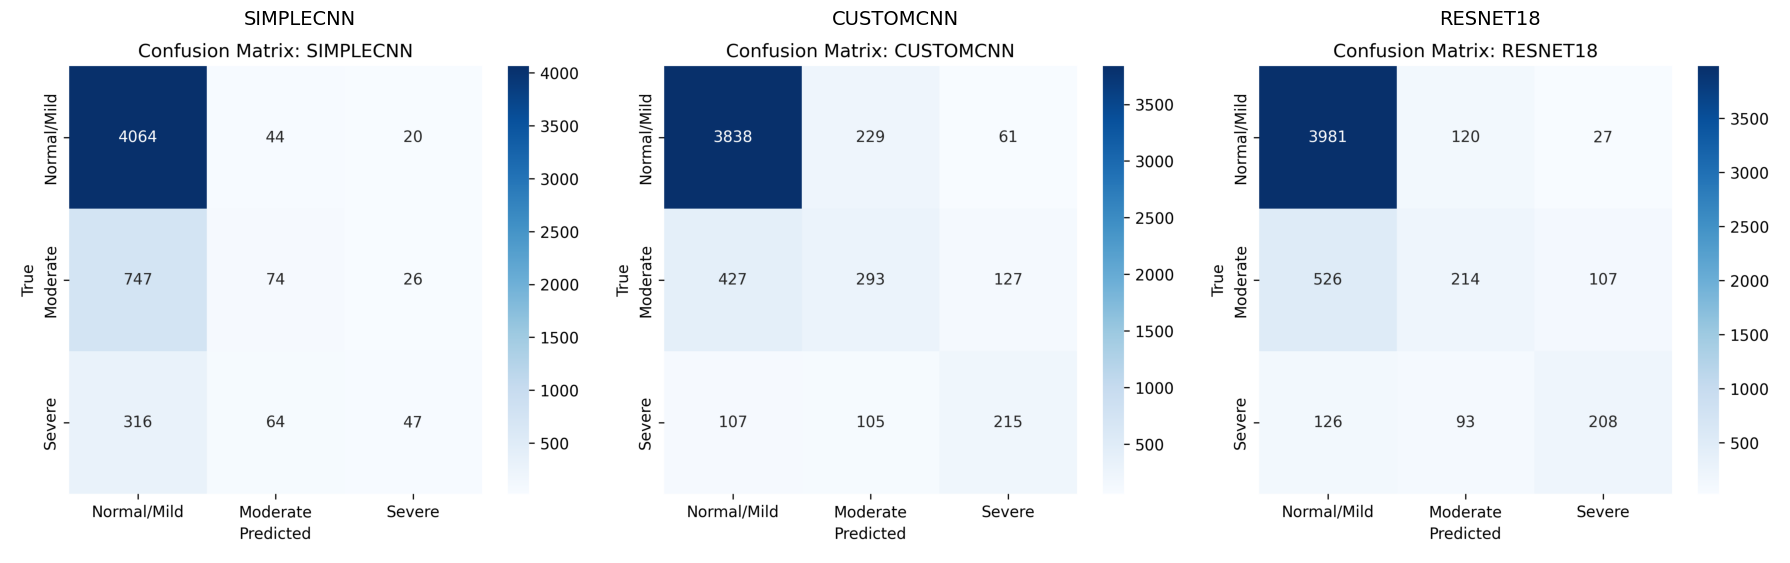

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Paths
FIGURE_DIR = "/content/drive/MyDrive/Final Project/figures"

# Model names
model_names = ["simplecnn", "customcnn", "resnet18"]

# Create a figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, model_name in zip(axes, model_names):
    img_path = os.path.join(FIGURE_DIR, f"confusion_matrix_{model_name}.png")
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axis
    ax.set_title(model_name.upper(), fontsize=14)

plt.tight_layout()

# ✅ Save **before** showing
comparison_path = os.path.join(FIGURE_DIR, "confusion_matrices_comparison.png")
plt.savefig(comparison_path, bbox_inches='tight', dpi=300)
print(f"✅ Saved side-by-side confusion matrices to {comparison_path}")

# Now display
plt.show()




✅ Saved ultra-tightly stacked training-curves to /content/drive/MyDrive/Final Project/models/training_curves_comparison_vertical_ultratight.png


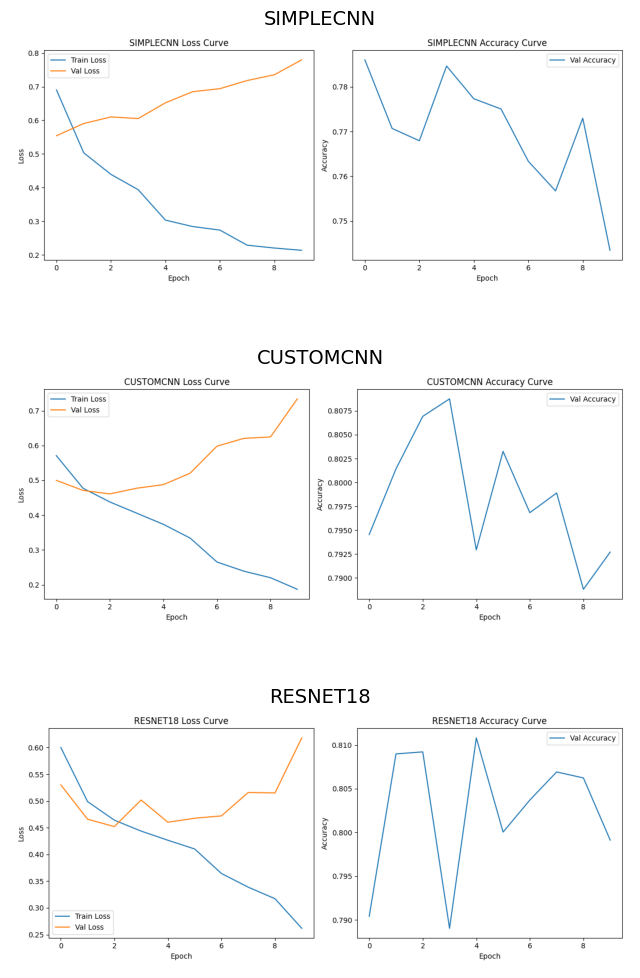

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Paths
FIGURE_DIR = "/content/drive/MyDrive/Final Project/models"

# Model names
model_names = ["simplecnn", "customcnn", "resnet18"]

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(8, 13))  # Slightly less tall
fig.subplots_adjust(hspace=0.05)  # 🔥 SUPER tight vertical space

for ax, model_name in zip(axes, model_names):
    img_path = os.path.join(FIGURE_DIR, f"{model_name}_training_curves.png")
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # No axes
    ax.set_title(model_name.upper(), fontsize=14, pad=5)  # Pad the title just a tiny bit

# Save BEFORE plt.show()
comparison_path = os.path.join(FIGURE_DIR, "training_curves_comparison_vertical_ultratight.png")
plt.savefig(comparison_path, bbox_inches='tight', dpi=300)
print(f"✅ Saved ultra-tightly stacked training-curves to {comparison_path}")

# Show
plt.show()